In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
import math

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

sns.set(rc={'figure.figsize':(20,8.27)})

In [2]:
df = pd.read_csv("../mpa_sim/services/pkls/radisys_testresult.csv")
df

,Test Case,Numerology,Bandwidth MHz,Modulation (QAM),RLC Mode,Number of cells,Number of UEs,DL (Mbps),UL (Mbps),CU cores,CU Overhead cores,DU cores,DU Overhead Cores,CU CPU Util %,DU CPU Util %,DU Overhead Cores Util %,TDD config,testCase
0,1,1,100,256,UM,1,1,1400,74,6,NaN,5,NaN,289.4,122.4,NaN,DDDSU,testbed
1,2,0,20,64,UM,1,1,235,56,1,NaN,2,NaN,40.0,21.0,NaN,DDDSU,simulation
2,3,0,20,64,UM,1,8,236,55,1,NaN,2,NaN,44.0,21.0,NaN,DDDSU,simulation
3,4,1,100,256,UM,6,8,6539,574,6,2.0,7,4.0,319.0,414.0,117.0,DDDSU,simulation
4,5,1,100,256,UM,6,20,6540,533,5,2.0,8,4.0,338.0,455.0,158.0,DDDSU,simulation
5,6,3,100,256,UM,6,8,6429,574,6,2.0,10,4.0,322.0,548.0,251.0,DDDSU,simulation
6,7,3,100,256,UM,6,20,6728,614,6,2.0,11,4.0,356.0,625.0,328.0,DDDSU,simulation


#### Data Pre-processing, Normalization, training Multivariate Regression model and Cost Model

In [3]:
X = df[['Numerology', 'Bandwidth MHz', 'Modulation (QAM)', 'Number of cells', 'Number of UEs', 'DL (Mbps)',
       'UL (Mbps)']].copy()
X['cell_x_ue'] = X.loc[:,'Number of cells'] * X.loc[:,'Number of UEs']
y_CU = df['CU CPU Util %']
y_DU = df['DU CPU Util %']
X

,Numerology,Bandwidth MHz,Modulation (QAM),Number of cells,Number of UEs,DL (Mbps),UL (Mbps),cell_x_ue
0,1,100,256,1,1,1400,74,1
1,0,20,64,1,1,235,56,1
2,0,20,64,1,8,236,55,8
3,1,100,256,6,8,6539,574,48
4,1,100,256,6,20,6540,533,120
5,3,100,256,6,8,6429,574,48
6,3,100,256,6,20,6728,614,120


In [4]:
#data normalization
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
lm_CU = linear_model.LinearRegression()
model_CU = lm_CU.fit(X_scaled,y_CU)
lm_DU = linear_model.LinearRegression()
model_DU = lm_DU.fit(X_scaled,y_DU)

In [6]:
def serv_calc(df, price):
    # We assume each core utilizes a max of 80% of its capabilites. 
    # So we can calculate the no. of cores = overall CPU Utilization/80(max utilization value) 
    df['Pred_CU_Cores'] = df['Pred_CU_Util'].apply(lambda x: math.ceil(x/80))
    df['Pred_DU_Cores'] = df['Pred_DU_Util'].apply(lambda x: math.ceil(x/80))

    # We take into consideration that server is Intel 6148 Xeon Gold Processor which has 20 cores. 
    # To find no. of servers = no.predicted cores/20 
    df['CU_Server_Count'] = df['Pred_CU_Cores'].apply(lambda x: math.ceil(x/20))
    df['DU_Server_Count'] = df['Pred_DU_Cores'].apply(lambda x: math.ceil(x/20))

    # tot server cost = no. of servers * cost of single server unit
    df['Tot.CU_Server_Cost'] = df['CU_Server_Count'] * price['6148']
    df['Tot.DU_Server_Cost'] = df['DU_Server_Count'] * price['6148']

    return df

### Config Parameters

In [7]:
config = {
    'Numerology': 1,
    'Bandwidth MHz': 100, 
    'Modulation (QAM)': 256, 
    'Number of cells': 18,
    'Number of UEs': 100, # per cell
    'DL (Mbps)': 1400, 
    'UL (Mbps)': 700, 
}
cpu_price = {
    '6148': 2988.39, 
    '6152': 3678.98, 
    '6210U': 891.49, 
    '6212U': 1607.20, 
    '6230': 1582.72
}

### Predict CU/CP CPU Utilization, Number of cores, servers and CPU costs 

In [8]:
config['cell_x_ue'] = config['Number of cells'] * config["Number of UEs"]
new_conf = pd.DataFrame([config])
new_conf_scaled = scaler.transform(new_conf)

new_conf['Pred_CU_Util'] = model_CU.predict(new_conf_scaled)
new_conf['Pred_DU_Util'] = model_DU.predict(new_conf_scaled)
prediction = serv_calc(new_conf,cpu_price)
print(f"CU Utilization (%): {prediction['Pred_CU_Util'][0]}" )
print(f"DU Utilization (%): {prediction['Pred_DU_Util'][0]}" )
prediction

CU Utilization (%): 709.7608330820449
DU Utilization (%): 1977.3009911627862


,Numerology,Bandwidth MHz,Modulation (QAM),Number of cells,Number of UEs,DL (Mbps),UL (Mbps),cell_x_ue,Pred_CU_Util,Pred_DU_Util,Pred_CU_Cores,Pred_DU_Cores,CU_Server_Count,DU_Server_Count,Tot.CU_Server_Cost,Tot.DU_Server_Cost
0,1,100,256,18,100,1400,700,1800,709.760833,1977.300991,9,25,1,2,2988.39,5976.78


In [9]:
UEs, du_utils, cu_utils, Cells = [], [], [], []
for i in range(10,1000,10):
    cells = i//20 +1
    config = {
        'Numerology': 1,
        'Bandwidth MHz': 100, 
        'Modulation (QAM)': 256, 
        'Number of cells': cells,
        'Number of UEs': i, 
        'DL (Mbps)': cells*1000, 
        'UL (Mbps)': cells*100, 
    }    
    config['cell_x_ue'] = config['Number of cells'] * config["Number of UEs"]
    new_conf = pd.DataFrame([config])
    new_conf = scaler.transform(new_conf)
    
    UEs.append(i)
    Cells.append(cells)
    du_utils.append(model_DU.predict(new_conf)[0])
    cu_utils.append(model_CU.predict(new_conf)[0])


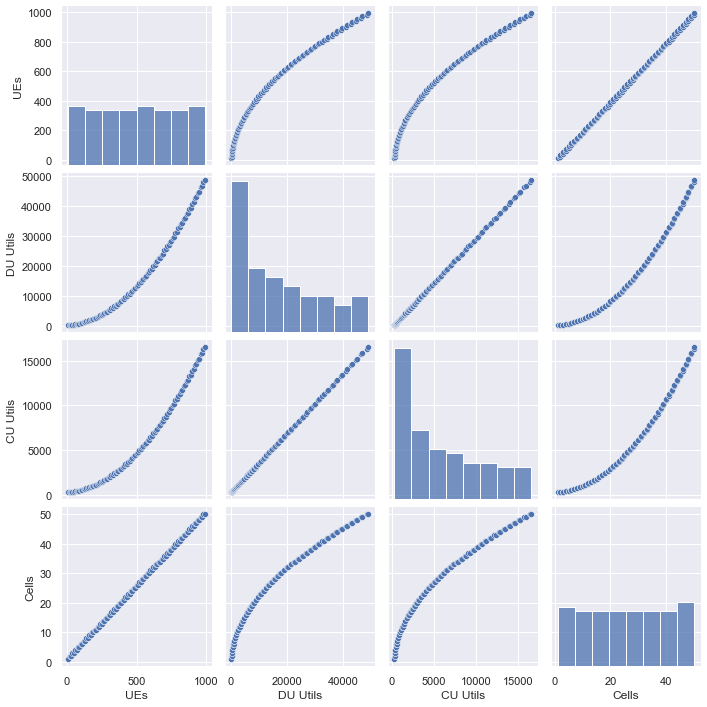

In [10]:
df_res = pd.DataFrame()
df_res['UEs'] = UEs
df_res['DU Utils'] = du_utils
df_res['CU Utils'] = cu_utils
df_res['Cells'] = Cells


sns.pairplot(df_res)

In [11]:
# sns.scatterplot(x='UEs',y='DU Utils', data=df_res)
# plt.title("Impact of number of UEs/Cells to DU CPU utilization \n max of 20 UEs per Cell")
# plt.xlabel("Number of UEs")
# plt.ylabel("Overall CPU Utilization")
# plt.show()

# sns.scatterplot(x='UEs',y='CU Utils', data=df_res)
# plt.title("Impact of number of UEs/Cells to CU CPU utilization \n max of 20 UEs per Cell")
# plt.xlabel("Number of UEs")
# plt.ylabel("Overall CPU Utilization")
# plt.show()

## Scenario 1: Impact of number of Cells to CU/DU server resources 
- Number of UEs = 500
- Number of Cells changed from 1 to 50 Cells
- Each Cell can handle 1Gbps DL and 100Mbps UL

In [12]:
d = pd.DataFrame()
UEs = 500

for cells in range(1,50,1):
    config = {
        'Numerology': 1,
        'Bandwidth MHz': 100, 
        'Modulation (QAM)': 256, 
        'Number of cells': cells,
        'Number of UEs': UEs, 
        'DL (Mbps)': cells*1000, 
        'UL (Mbps)': cells*100, 
    }    
 
    d = pd.concat([d, pd.DataFrame([config])])
    
d.reset_index(drop=True, inplace=True)
d['cell_x_ue'] = d['Number of cells'] * d["Number of UEs"]
d_scaled = scaler.transform(d)

d['Pred_CU_Util'] = model_CU.predict(d_scaled)
d['Pred_DU_Util'] = model_DU.predict(d_scaled)
d = serv_calc(d,cpu_price)

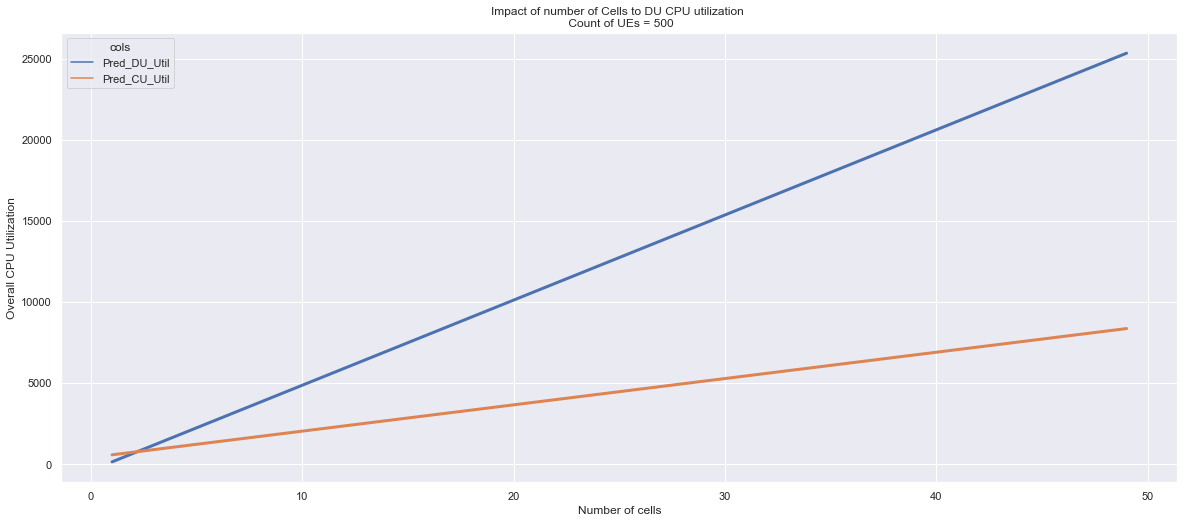

In [13]:
_d = d[["Number of cells","Pred_DU_Util", "Pred_CU_Util"]].melt('Number of cells', var_name='cols',  value_name='Overall CPU Utilization')
plt.title("Impact of number of Cells to DU CPU utilization \n Count of UEs = 500")
g = sns.lineplot(x="Number of cells", y="Overall CPU Utilization", hue='cols', data=_d, linewidth = 3)


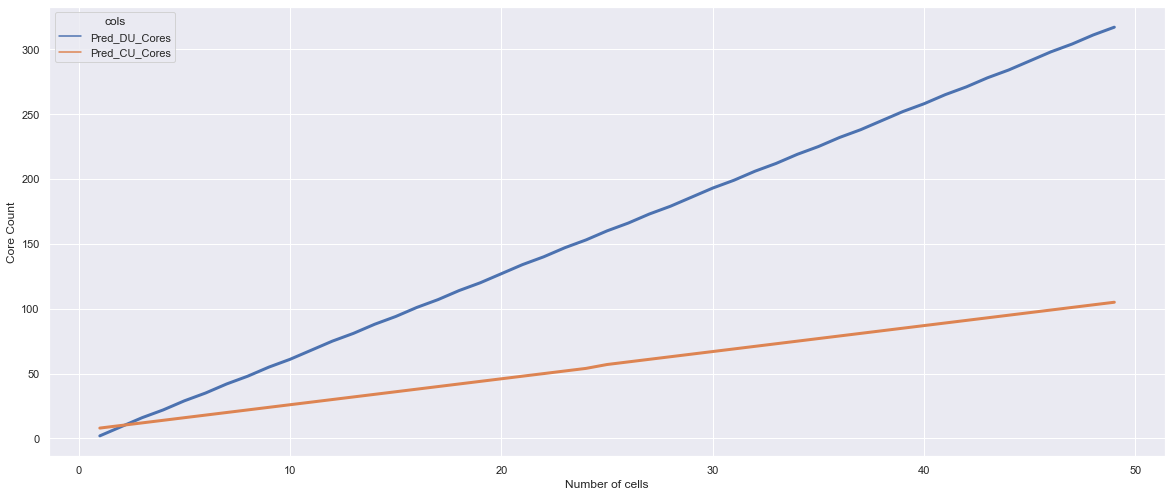

In [14]:
_d = d[["Number of cells","Pred_DU_Cores", "Pred_CU_Cores"]].melt('Number of cells', var_name='cols',  value_name='Core Count')
g = sns.lineplot(x="Number of cells", y="Core Count", hue='cols', data=_d, linewidth = 3)

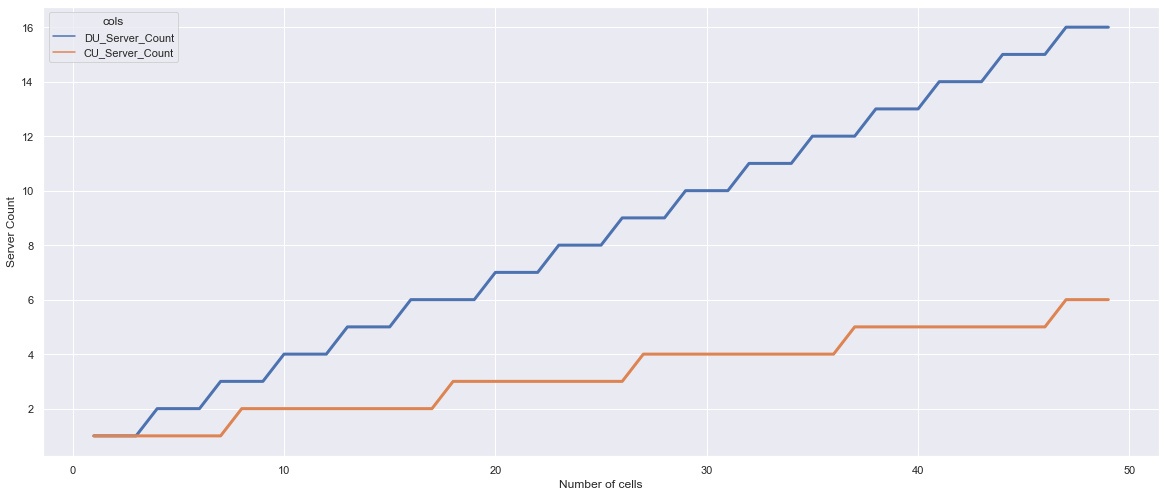

In [15]:
_d = d[["Number of cells","DU_Server_Count", "CU_Server_Count"]].melt('Number of cells', var_name='cols',  value_name='Server Count')
g = sns.lineplot(x="Number of cells", y="Server Count", hue='cols', data=_d, linewidth = 3)

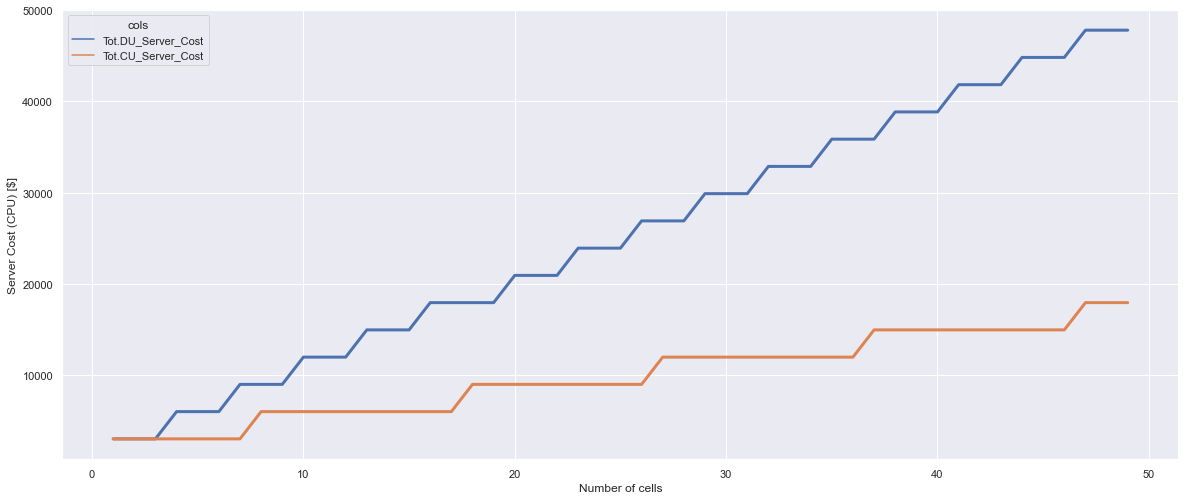

In [16]:
_d = d[["Number of cells","Tot.DU_Server_Cost", "Tot.CU_Server_Cost"]].melt('Number of cells', var_name='cols',  value_name='Server Cost (CPU) [$]')
g = sns.lineplot(x="Number of cells", y="Server Cost (CPU) [$]", hue='cols', data=_d, linewidth = 3)

## Scenario 2
- Number of UEs changed from 10 to 1000
- Maximum of 20 UEs per Cell
- Each Cell can handle 1 Gbps DL and 100 Mbps UL

In [17]:
d = pd.DataFrame()
for i in range(10,1000,10):
    cells = i//20 +1
    config = {
        'Numerology': 1,
        'Bandwidth MHz': 100, 
        'Modulation (QAM)': 256, 
        'Number of cells': cells,
        'Number of UEs': i, 
        'DL (Mbps)': cells*1000, 
        'UL (Mbps)': cells*100, 
    }    
    d = pd.concat([d, pd.DataFrame([config])])
    
d.reset_index(drop=True, inplace=True)
d['cell_x_ue'] = d['Number of cells'] * d["Number of UEs"]
d_scaled = scaler.transform(d)

d['Pred_CU_Util'] = model_CU.predict(d_scaled)
d['Pred_DU_Util'] = model_DU.predict(d_scaled)
d = serv_calc(d,cpu_price)

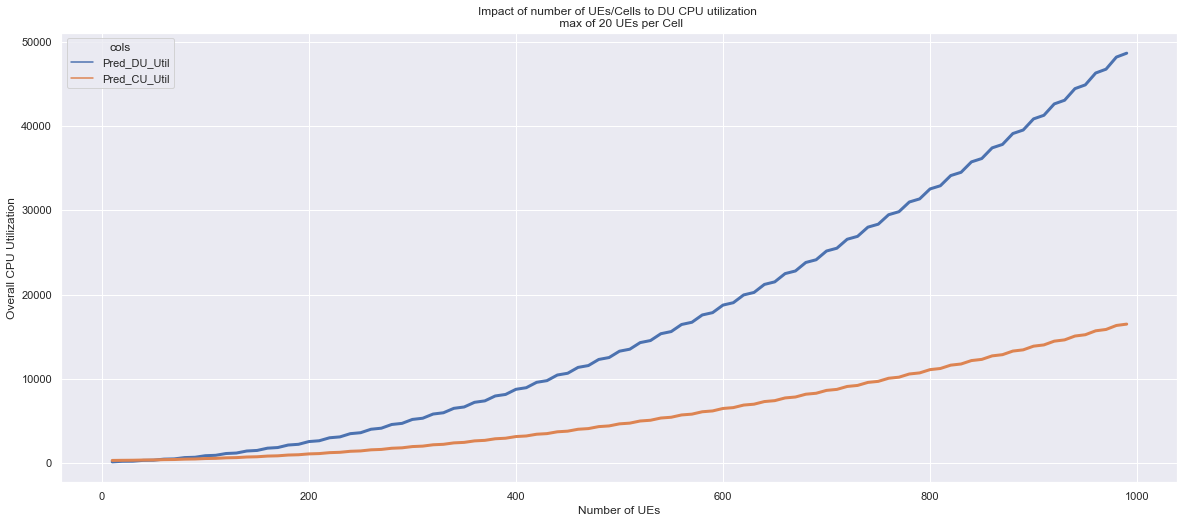

In [18]:
_d = d[["Number of UEs","Pred_DU_Util", "Pred_CU_Util"]].melt('Number of UEs', var_name='cols',  value_name='Overall CPU Utilization')
plt.title("Impact of number of UEs/Cells to DU CPU utilization \n max of 20 UEs per Cell")
g = sns.lineplot(x="Number of UEs", y="Overall CPU Utilization", hue='cols', data=_d, linewidth = 3)


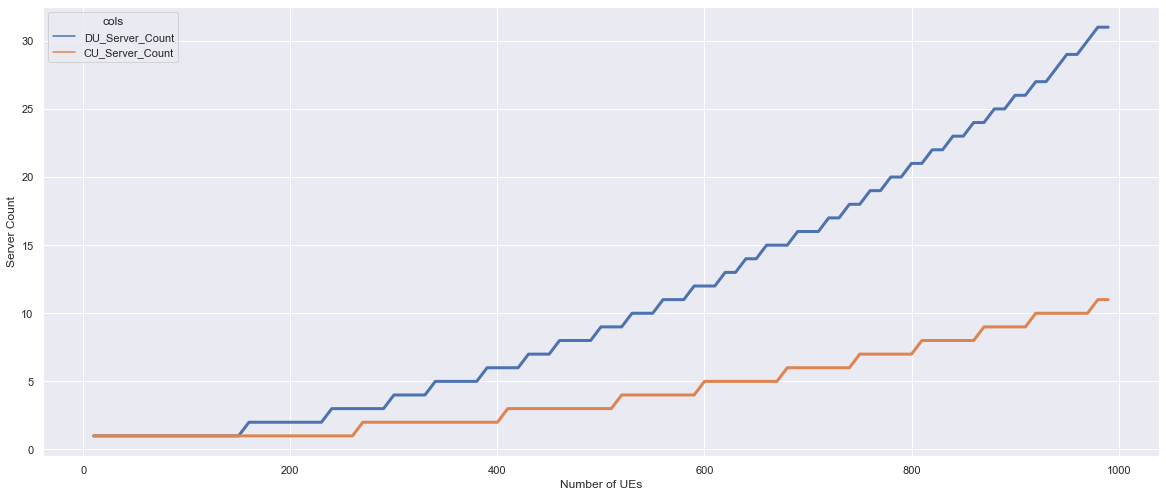

In [19]:
_d = d[["Number of UEs","DU_Server_Count", "CU_Server_Count"]].melt('Number of UEs', var_name='cols',  value_name='Server Count')
g = sns.lineplot(x="Number of UEs", y="Server Count", hue='cols', data=_d, linewidth = 3)

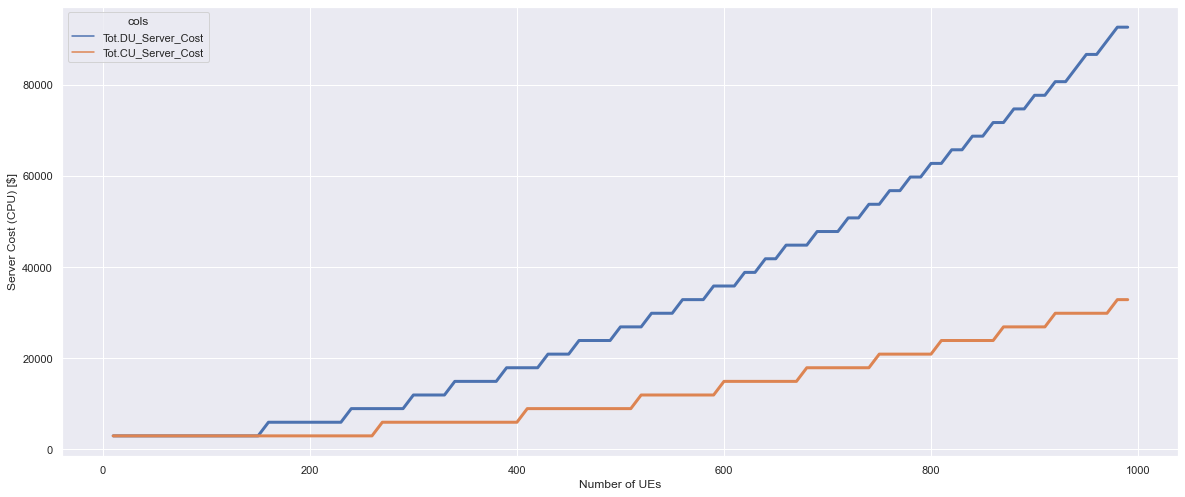

In [20]:
_d = d[["Number of UEs","Tot.DU_Server_Cost", "Tot.CU_Server_Cost"]].melt('Number of UEs', var_name='cols',  value_name='Server Cost (CPU) [$]')
g = sns.lineplot(x="Number of UEs", y="Server Cost (CPU) [$]", hue='cols', data=_d, linewidth = 3)